In [1]:
import os

new_directory = "/home/geon/dev_geon/ml-testbed"  # 변경하고자 하는 새 디렉토리 경로로 대체
os.chdir(new_directory)

In [2]:
import os

current_directory = os.getcwd()
print("현재 작업 디렉토리:", current_directory)

현재 작업 디렉토리: /home/geon/dev_geon/ml-testbed


In [292]:
import torch
from src.models.components.conv_lstm_classifier_no_dropout_outputsize_control import CONV_LSTM_Classifier
# 모델 불러오기

loaded_model = CONV_LSTM_Classifier(use_fft_stat = False, topk_freq=5, output_size= 128,lstm_hidden_size = 64, dense1_out_size = 64, dense2_out_size= 32, metadata_embedding = True,use_raw = False, use_envelope = True, use_stat = True,  use_eofft= True, use_envelope_spectrum = True, use_bandpass = True)

# 모델 가중치 불러오기
loaded_model.load_state_dict(torch.load('/home/geon/dev_geon/ml-testbed/src/models/components/ProtoNet_mixup_triplet_no_embedding.pth'))
#ProtoNet_mixup_triplet_no_embedding
#ProtoNet_no_mixup_triplet_no_embedding


<All keys matched successfully>

In [4]:
loaded_model

CONV_LSTM_Classifier(
  (mix_style): MixStyle()
  (dropout): Dropout(p=0.3, inplace=False)
  (fft_real): FFTReal()
  (fft_hs): FFT_Health_State_Analysis()
  (hs): Health_State_Analysis()
  (layer_norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  (layer_norm2): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
  (silu): SiLU()
  (maxpool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv1): Conv1d(12, 16, kernel_size=(64,), stride=(4,), padding=(1,))
  (batchnorm1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv1d(16, 32, kernel_size=(32,), stride=(2,), padding=(1,))
  (batchnorm2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv1d(32, 64, kernel_size=(16,), stride=(2,), padding=(1,))
  (batchnorm3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv1d(64, 8, kernel_size=(8,), stride=(1,), padding=

In [5]:
from typing import List,Tuple
import librosa
fault_type_dict = {"정상": 0,
              "베어링불량": 1,
              "벨트느슨함": 2,
              "축정렬불량": 3,
              "회전체불평형": 4}
root: str = "/home/mongoose01/mongooseai/data/cms/open_source/AI_hub/기계시설물 고장 예지 센서/Training/vibration"

In [6]:
import numpy as np
import math
import librosa
def sampling_with_bandpass(data , sf, rf):
    rotational_frequency = rf  # 회전 주파수 30Hz
    frequencies_to_filter = [rotational_frequency * i for i in range(1, 9)]  # 1배, 2배, 3배, 4배 주파수
    frequencies_to_filter.append(120)  # 추가적으로 120Hz 필터링

    # 대역폭 설정 (+/- 10Hz)
    bandwidth = 10

    # 예제 신호 생성: 여러 주파수 성분과 잡음 포함

    # 필터링된 신호를 저장할 딕셔너리
    filtered_signals = []

    # 각 주파수 대역에 대한 필터링
    for f in frequencies_to_filter:
        band = [f - bandwidth, f + bandwidth]
        b, a = signal.butter(4, [band[0]/(sf/2), band[1]/(sf/2)], btype='band')
        analytic_signal = signal.hilbert(signal.filtfilt(b, a, data))
        # Compute the envelope
        envelope = np.abs(analytic_signal)
        filtered_signals.append(envelope)

    return np.stack(filtered_signals, axis=1)

def original_fft(signal,sf):
    _signal = signal
    y = np.abs(np.fft.fft(_signal,axis = 0)/len(signal))        # fft computing and normaliation
    y = y[range(math.trunc(len(signal)/2))]  
    k = np.arange(len(signal))
    f0=k*sf/len(signal)    # double sides frequency range
    f0=f0[range(math.trunc(len(signal)/2))]  
    return f0, y

def is_peak_at_frequency(freq, spectrum,threshold):
    # 실제 구현에선 주파수 스펙트럼에서 해당 주파수의 진폭이 피크를 형성하는지 검사
    return spectrum[int(freq)] > threshold
                
def estimate_rpm(numpy_array, sf=8192, f_min=27.6, f_max=29.1, f_r=1, M=60, c=2):

    f, magnitude_spectrum = original_fft(numpy_array, sf)
    # 속도 후보들과 그에 대한 초기 확률 설정
    candidates = np.arange(f_min, f_max, f_r/M)
    probabilities = np.ones_like(candidates)  # 모든 후보에 동일한 초기 확률 할당
    #print(f"3분위수 :{np.percentile(magnitude_spectrum, 75)}")
    #print(f"중위수 : {np.percentile(magnitude_spectrum, 50)}")
    #print(f"평균 : {np.mean(magnitude_spectrum)}")
    #print(f"최대 : {np.max(magnitude_spectrum)}")
    threshold = np.mean(magnitude_spectrum)*1.5
    # 후보들의 조화 검사 및 확률 업데이트
    for i, fc in enumerate(candidates):
        for k in range(1, M+1):
            harmonic_freq = k * fc
                    
            if not is_peak_at_frequency(harmonic_freq, magnitude_spectrum,threshold):
                probabilities[i] /= c  # 피크가 없으면 확률 감소
                # 최종 추정 속도 결정
    estimated_speed = candidates[np.argmax(probabilities)]


    #print(f'Estimated speed: {estimated_speed} Estimated rpm: {estimated_speed*60}')
    return estimated_speed*60

def engine_order_fft(signal, rpm, sf = 8192, res = 100, ts = 1):
    _signal = signal[:int(sf*ts)]
    pad_length = int(sf*(res * 60/rpm - ts))
    zero_padded_signal = np.concatenate((_signal, np.zeros(pad_length)))
    y = np.abs(np.fft.fft(zero_padded_signal)/len(zero_padded_signal))     
    y = y[range(math.trunc(len(signal)))]     
    return y[:sf]

def min_max_scaling(data, new_min=-1, new_max=1):
    min_val = np.min(data)
    max_val = np.max(data)
    scaled_data = new_min + (data - min_val) * (new_max - new_min) / (max_val - min_val)
    return scaled_data

def standard_scaling(data):
    mean = np.mean(data,axis = 0 )
    std = np.std(data,axis = 0 )
    scaled_data = (data - mean) / (std + 1e-8)
    return scaled_data

In [7]:
import scipy
import random
def envelope_spectrum(signal, fs):
        """
        Compute the envelope spectrum of a signal.
        
        Args:
        signal (numpy array): Input signal.
        fs (float): Sampling frequency of the signal.
        
        Returns:
        freqs (numpy array): Frequencies of the envelope spectrum.
        envelope (numpy array): Envelope spectrum of the signal.
        """
        # Compute the analytic signal using Hilbert transform
        analytic_signal = scipy.signal.hilbert(signal)
        # Compute the envelope
        envelope = np.abs(analytic_signal)

        # Compute the FFT of the envelope
        envelope_fft = np.fft.fft(envelope)
        # Compute the corresponding frequencies
        freqs = np.fft.fftfreq(len(envelope), 1 / fs)
        
        # Take only the positive frequencies and their corresponding FFT values

        freqs = freqs[:]
        envelope_fft = np.abs(envelope_fft[:])

        return envelope, envelope_fft
def up_sample(input_wav, origin_sr, resample_sr, upsample_method):
        resample = librosa.resample(y=input_wav, orig_sr=origin_sr, target_sr=resample_sr, res_type=upsample_method)
        return resample

def calculate_rms(input):
    input = input.reshape(-1,1)#make input 1D array
    """
    input : signal, 1D array

    Do: calculate rms for input 
    """
    return np.sqrt(np.mean(input**2))

 


def process_csv( csv_path, fault):
        data = np.loadtxt(csv_path, delimiter=',', skiprows=9, usecols=(1,), max_rows=4000)
        data = standard_scaling(data*100)
        data = up_sample(data, 4000, 8192, "soxr_vhq")
        rpm = estimate_rpm(data)
        bandpassed_signal = sampling_with_bandpass(data, 8192, rpm/60)
        eofft = engine_order_fft(data,rpm)
        envelope, envelop_spectrum = envelope_spectrum(data,8192)

        return data.reshape(-1,1), bandpassed_signal.reshape(-1,9), envelope.reshape(-1,1), envelop_spectrum.reshape(-1,1), eofft.reshape(-1,1), fault_type_dict[fault]
    
    # Process the CSV files for each motor power
def process_motor_power( data_root, motor_power, jump_size, fault_type_count_list,motor_dict):
        data_list = []
        target_list = []
        motor_power_path = os.path.join(data_root, motor_power)
        for motor in os.listdir(motor_power_path):
            for fault in os.listdir(os.path.join(motor_power_path, motor)):
                if fault == "정상":
                      continue
                motor_path = os.path.join(motor_power_path, motor, fault)
                csv_list = [file for file in os.listdir(motor_path) if file.endswith('.csv')]
                random.shuffle(csv_list)    
                cnt = 0
                for csv in csv_list[0:int(len(csv_list)):jump_size]:
                    
                    numpy_array, bandpassed_signal_array, envelope_array, envelop_spectrum_array, eofft, target = process_csv(os.path.join(motor_path,csv), fault)
                    motor_power_array = np.ones_like(numpy_array)*float(str(motor_power[:-2]))
                    motor_array = np.ones_like(numpy_array)*motor_dict[motor]
                    """
                    np.save(os.path.join(motor_path, 'numpy_array_' + str(cnt)+ '.npy'), numpy_array)
                    np.save(os.path.join(motor_path, 'bandpassed_signal_' + str(cnt)+ '.npy'), bandpassed_signal)
                    np.save(os.path.join(motor_path, 'envelope_' + str(cnt)+ '.npy'), envelope)
                    np.save(os.path.join(motor_path, 'envelop_spectrum_' + str(cnt)+ '.npy'), envelop_spectrum)
                    np.save(os.path.join(motor_path, 'eofft_' + str(cnt)+ '.npy'), eofft)
                    np.save(os.path.join(motor_path, 'target_' + str(cnt)+ '.npy'), target)
                    """
                    cnt += 1
                    data = np.concatenate([numpy_array, bandpassed_signal_array, envelope_array, envelop_spectrum_array, eofft, motor_power_array,motor_array], axis = -1)
                    data_list.append(data)
                    target_list.append(target)
                    
                    """
                    numpy_array = np.load(os.path.join(motor_path, 'numpy_array_' + str(cnt)+ '.npy'))
                    motor_power_array = np.ones_like(numpy_array)*float(str(motor_power[:-2]))
                    bandpassed_signal_array = np.load(os.path.join(motor_path, 'bandpassed_signal_' + str(cnt)+ '.npy'))
                    envelope_array = np.load(os.path.join(motor_path, 'envelope_' + str(cnt)+ '.npy'))
                    envelop_spectrum_array = np.load(os.path.join(motor_path, 'envelop_spectrum_' + str(cnt)+ '.npy'))
                    eofft = np.load(os.path.join(motor_path, 'eofft_' + str(cnt)+ '.npy'))
                    target = np.load(os.path.join(motor_path, 'target_' + str(cnt)+ '.npy'))
                    cnt += 1
                    data = np.concatenate([numpy_array, bandpassed_signal_array, envelope_array, envelop_spectrum_array, eofft, motor_power_array], axis = -1)
                    data_list.append(data)
                    target_list.append(target.item())
                    """
        return data_list, target_list
def process_motor_power_normal( data_root, motor_power, jump_size, fault_type_count_list,motor_dict):
        data_list = []
        target_list = []
        motor_power_path = os.path.join(data_root, motor_power)
        for motor in os.listdir(motor_power_path):
            for fault in os.listdir(os.path.join(motor_power_path, motor)):
                if fault == "정상":
                    motor_path = os.path.join(motor_power_path, motor, fault)
                    csv_list = [file for file in os.listdir(motor_path) if file.endswith('.csv')]
                    random.shuffle(csv_list)    
                    cnt = 0
                    for csv in csv_list[0:int(len(csv_list)):jump_size]:  # Taking first 2000 files after shuffling
                        
                        numpy_array, bandpassed_signal_array, envelope_array, envelop_spectrum_array, eofft, target = process_csv(os.path.join(motor_path,csv), fault)
                        motor_power_array = np.ones_like(numpy_array)*float(str(motor_power[:-2]))
                        motor_array = np.ones_like(numpy_array)*motor_dict[motor]
                        """
                        np.save(os.path.join(motor_path, 'numpy_array_' + str(cnt)+ '.npy'), numpy_array)
                        np.save(os.path.join(motor_path, 'bandpassed_signal_' + str(cnt)+ '.npy'), bandpassed_signal)
                        np.save(os.path.join(motor_path, 'envelope_' + str(cnt)+ '.npy'), envelope)
                        np.save(os.path.join(motor_path, 'envelop_spectrum_' + str(cnt)+ '.npy'), envelop_spectrum)
                        np.save(os.path.join(motor_path, 'eofft_' + str(cnt)+ '.npy'), eofft)
                        np.save(os.path.join(motor_path, 'target_' + str(cnt)+ '.npy'), target)
                        """
                        cnt += 1
                        data = np.concatenate([numpy_array, bandpassed_signal_array, envelope_array, envelop_spectrum_array, eofft, motor_power_array,motor_array], axis = -1)
                        data_list.append(data)
                        target_list.append(target)
                        
                        """
                        numpy_array = np.load(os.path.join(motor_path, 'numpy_array_' + str(cnt)+ '.npy'))
                        motor_power_array = np.ones_like(numpy_array)*float(str(motor_power[:-2]))
                        bandpassed_signal_array = np.load(os.path.join(motor_path, 'bandpassed_signal_' + str(cnt)+ '.npy'))
                        envelope_array = np.load(os.path.join(motor_path, 'envelope_' + str(cnt)+ '.npy'))
                        envelop_spectrum_array = np.load(os.path.join(motor_path, 'envelop_spectrum_' + str(cnt)+ '.npy'))
                        eofft = np.load(os.path.join(motor_path, 'eofft_' + str(cnt)+ '.npy'))
                        target = np.load(os.path.join(motor_path, 'target_' + str(cnt)+ '.npy'))
                        cnt += 1
                        data = np.concatenate([numpy_array, bandpassed_signal_array, envelope_array, envelop_spectrum_array, eofft, motor_power_array], axis = -1)
                        data_list.append(data)
                        target_list.append(target.item())
                        """
        return data_list, target_list

In [8]:
import os
import tqdm
from typing import List, Tuple
import librosa
import scipy.signal as signal
#["2.2kW","3.7kW","15kW","37kW","7.5kW","18.5kW","30kW","55kW","22kW"]
#["7.5kW","18.5kW","30kW","55kW","22kW"]
val_motor_power: List[str] = []
test_motor_power: List[str] = ["5.5kW"]
fault_type_dict = {
    "정상": 0,
    "베어링불량": 1,
    "벨트느슨함": 2,
    "축정렬불량": 3,
    "회전체불평형": 4
}
root: str = "/home/mongoose01/mongooseai/data/cms/open_source/AI_hub/기계시설물 고장 예지 센서/Training/vibration"

motor_list = []
train_target_list = []
fault_type_count_list = [0,0,0,0,0]
train_motor_power = sorted(list(set(os.listdir(root)) - set(test_motor_power) - set(val_motor_power)))#- set(val_motor_power)
for motor_power in test_motor_power:
    motor_power_path = os.path.join(root, motor_power)
    for motor in os.listdir(motor_power_path):
        motor_list.append(motor)
for motor_power in val_motor_power:
    motor_power_path = os.path.join(root, motor_power)
    for motor in os.listdir(motor_power_path):
        motor_list.append(motor)
for motor_power in train_motor_power:
    motor_power_path = os.path.join(root, motor_power)  
    for motor in os.listdir(motor_power_path):
        motor_list.append(motor)
unique_motor_list = list(set(motor_list))

# Create a dictionary to hold motor names and their vectorized representations
motor_dict = {}
for index, motor_name in enumerate(unique_motor_list):
    motor_dict[motor_name] = index  
test_data_list = []
test_target_list = []
test_rms_list = []
fault_type_count_list = [0, 0, 0, 0, 0]

for motor_power in test_motor_power:
    motor_power_path = os.path.join(root, motor_power)
    for motor in os.listdir(motor_power_path):
        for fault in os.listdir(os.path.join(motor_power_path, motor)):
            fault_type_count_list[fault_type_dict[fault]] += 1

print(fault_type_count_list)

for motor_power in tqdm.tqdm(test_motor_power, desc='Processing Motor Powers'):
    test_motor_data, test_motor_targets = process_motor_power(root, motor_power, 50, fault_type_count_list,motor_dict)

fault_type_count_list = [0, 0, 0, 0, 0]
train_motor_power = sorted(list(set(os.listdir(root))  - set(test_motor_power) - set(val_motor_power)))
for motor_power in train_motor_power:
    motor_power_path = os.path.join(root, motor_power)
    for motor in os.listdir(motor_power_path):
        for fault in os.listdir(os.path.join(motor_power_path, motor)):
            fault_type_count_list[fault_type_dict[fault]] += 1

print(fault_type_count_list)
val_data_list = []
val_target_list = []
for motor_power in tqdm.tqdm(train_motor_power, desc='Processing Motor Powers'):
    val_motor_data, val_motor_targets = process_motor_power(root, motor_power, 200, fault_type_count_list,motor_dict)
    val_data_list.extend(val_motor_data)
    val_target_list.extend(val_motor_targets)
"""
for motor_power in tqdm.tqdm(test_motor_power, desc='Processing Motor Powers'):
            motor_data, motor_targets = process_motor_power_normal(root, motor_power, 200, fault_type_count_list,motor_dict)
            val_data_list.extend(motor_data)
            val_target_list.extend(motor_targets)
  
"""

[4, 1, 1, 1, 1]


Processing Motor Powers: 100%|██████████| 1/1 [00:28<00:00, 28.37s/it]


[22, 6, 6, 5, 5]


Processing Motor Powers: 100%|██████████| 11/11 [00:39<00:00,  3.55s/it]


"\nfor motor_power in tqdm.tqdm(test_motor_power, desc='Processing Motor Powers'):\n            motor_data, motor_targets = process_motor_power_normal(root, motor_power, 200, fault_type_count_list,motor_dict)\n            val_data_list.extend(motor_data)\n            val_target_list.extend(motor_targets)\n  \n"

In [9]:

test_stacked_array = np.stack(test_motor_data[:],axis = 0)
val_stacked_array = np.stack(val_data_list[:],axis = 0)



In [293]:

test_hi = loaded_model.forward(torch.Tensor(test_stacked_array))
val_hi = loaded_model.forward(torch.Tensor(val_stacked_array))

In [294]:

test_bye = loaded_model.fault_classfier(test_hi)
val_bye = loaded_model.fault_classfier(val_hi)


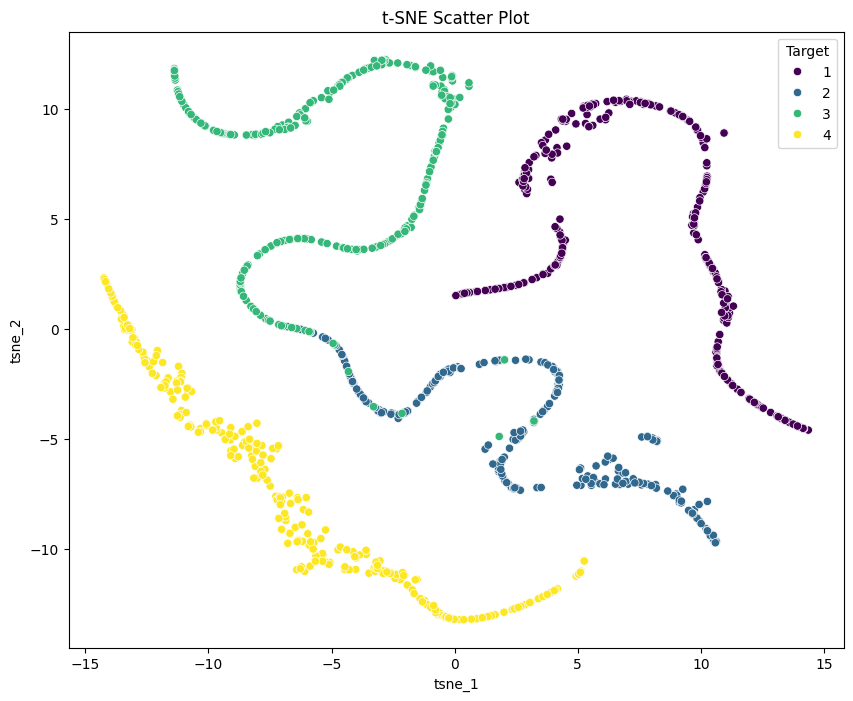

In [295]:
import pandas as pd
import numpy as np
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt

# 임베딩 결과와 타겟 레이블 데이터 예시 (임의로 생성)
embeddings = test_bye.detach().numpy()  # requires_grad=False로 설정한 데이터
target_labels = test_motor_targets  # 타겟 레이블 리스트

# t-SNE 모델 생성 및 학습
tsne = TSNE(n_components=2, perplexity=30, n_iter=300)
tsne_results = tsne.fit_transform(embeddings)

# 결과를 데이터 프레임으로 변환
tsne_df = pd.DataFrame(data={'tsne_1': tsne_results[:, 0], 'tsne_2': tsne_results[:, 1], 'Target': target_labels[:]})

# Seaborn을 사용하여 산점도 그리기
plt.figure(figsize=(10, 8))
sns.scatterplot(data=tsne_df, x='tsne_1', y='tsne_2', hue='Target', palette='viridis')

# 그래프 제목 추가
plt.title('t-SNE Scatter Plot')

# 그래프 표시
plt.show()


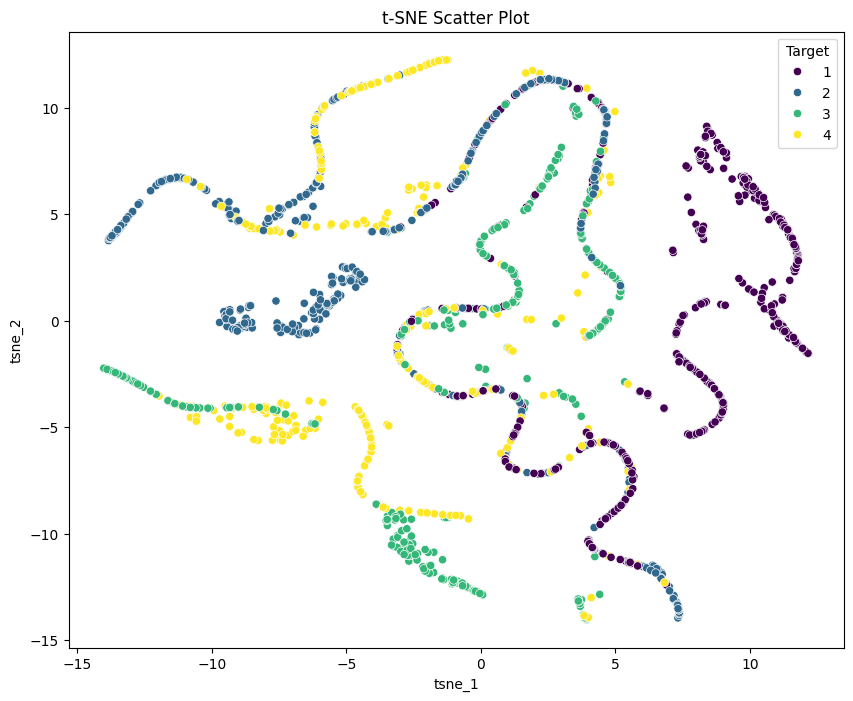

In [296]:
import pandas as pd
import numpy as np
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt

# 임베딩 결과와 타겟 레이블 데이터 예시 (임의로 생성)
embeddings = val_bye.detach().numpy()  # requires_grad=False로 설정한 데이터
target_labels = val_target_list  # 타겟 레이블 리스트

# t-SNE 모델 생성 및 학습
tsne = TSNE(n_components=2, perplexity=30, n_iter=300)
tsne_results = tsne.fit_transform(embeddings)

# 결과를 데이터 프레임으로 변환
tsne_df = pd.DataFrame(data={'tsne_1': tsne_results[:, 0], 'tsne_2': tsne_results[:, 1], 'Target': target_labels[:]})

# Seaborn을 사용하여 산점도 그리기
plt.figure(figsize=(10, 8))
sns.scatterplot(data=tsne_df, x='tsne_1', y='tsne_2', hue='Target', palette='viridis')

# 그래프 제목 추가
plt.title('t-SNE Scatter Plot')

# 그래프 표시
plt.show()


In [297]:
np.concatenate([val_bye.detach().numpy( ),test_bye.detach().numpy( )]).shape

(3156, 128)

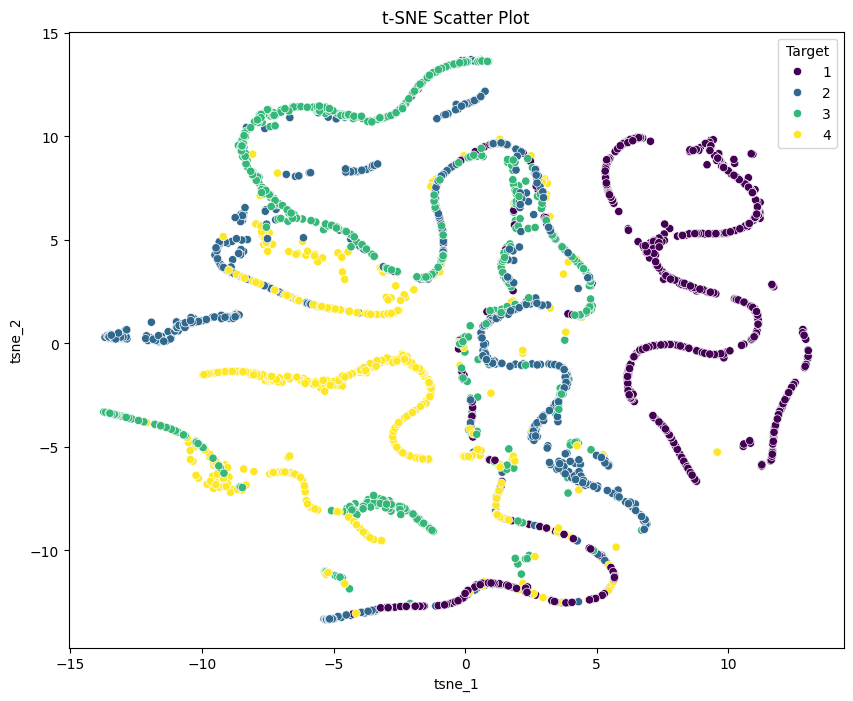

In [298]:
import pandas as pd
import numpy as np
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt

# 임베딩 결과와 타겟 레이블 데이터 예시 (임의로 생성)
embeddings = np.concatenate([val_bye.detach().numpy( ),test_bye.detach().numpy( )])# requires_grad=False로 설정한 데이터
target_labels = val_target_list + test_motor_targets # 타겟 레이블 리스트

# t-SNE 모델 생성 및 학습
tsne = TSNE(n_components=2, perplexity=30, n_iter=300)
tsne_results = tsne.fit_transform(embeddings)

# 결과를 데이터 프레임으로 변환
tsne_df = pd.DataFrame(data={'tsne_1': tsne_results[:, 0], 'tsne_2': tsne_results[:, 1], 'Target': target_labels[:]})

# Seaborn을 사용하여 산점도 그리기
plt.figure(figsize=(10, 8))
sns.scatterplot(data=tsne_df, x='tsne_1', y='tsne_2', hue='Target', palette='viridis')

# 그래프 제목 추가
plt.title('t-SNE Scatter Plot')

# 그래프 표시
plt.show()


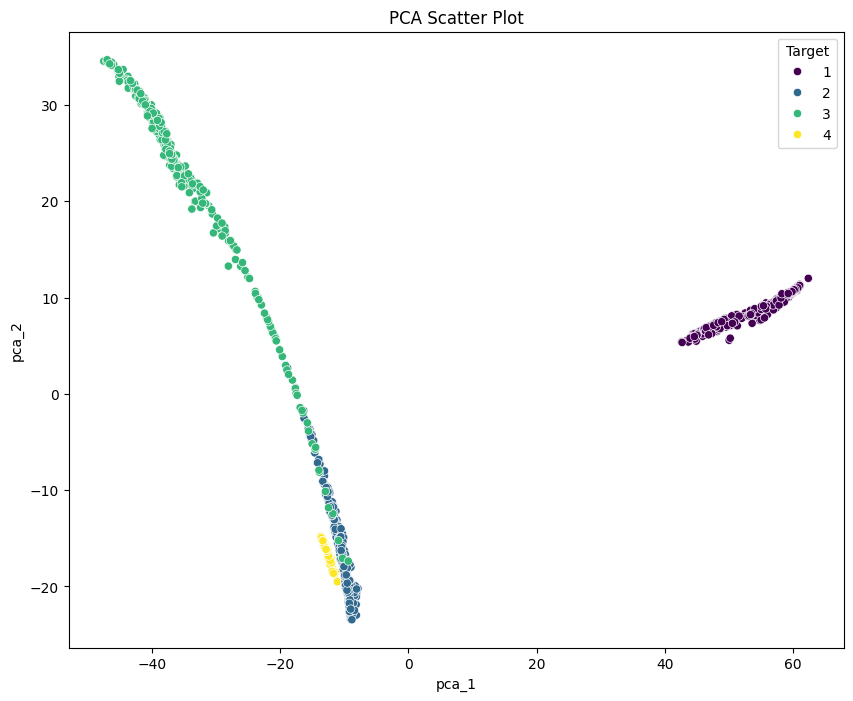

In [299]:
import numpy as np
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt

# 임베딩 결과와 타겟 레이블 데이터 예시 (임의로 생성)
embeddings =test_bye.detach().numpy()  # requires_grad=False로 설정한 데이터
target_labels = test_motor_targets  # 타겟 레이블 리스트

# PCA 모델 생성 및 학습
pca = PCA(n_components=2)
pca_results = pca.fit_transform(embeddings)

# 결과를 데이터 프레임으로 변환
pca_df = pd.DataFrame(data={'pca_1': pca_results[:, 0], 'pca_2': pca_results[:, 1], 'Target': target_labels[:]})

# Seaborn을 사용하여 산점도 그리기
plt.figure(figsize=(10, 8))
sns.scatterplot(data=pca_df, x='pca_1', y='pca_2', hue='Target', palette='viridis')

# 그래프 제목 추가
plt.title('PCA Scatter Plot')

# 그래프 표시
plt.show()


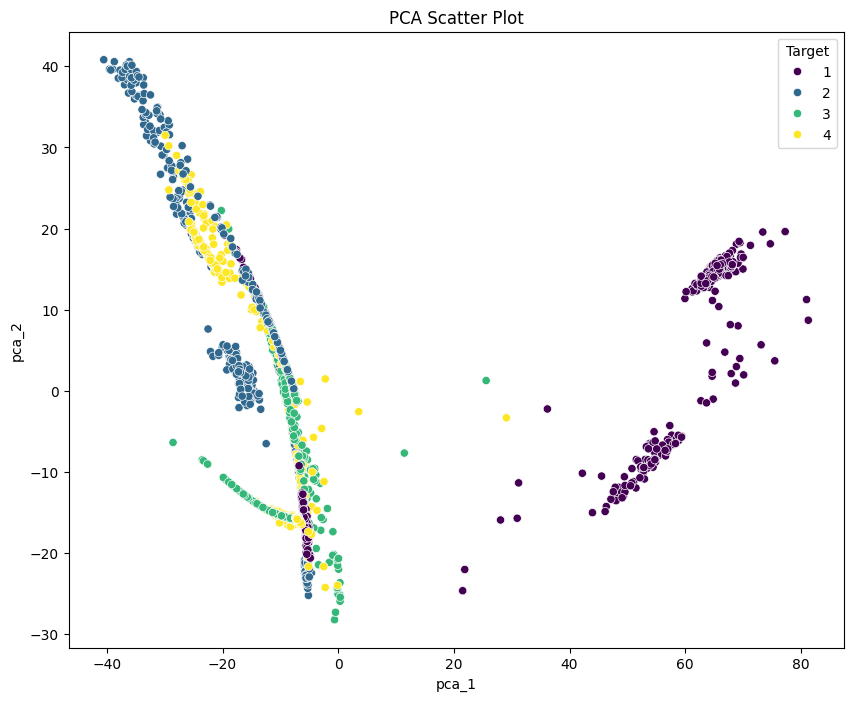

In [300]:
import numpy as np
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt

# 임베딩 결과와 타겟 레이블 데이터 예시 (임의로 생성)
embeddings =val_bye.detach().numpy()  # requires_grad=False로 설정한 데이터
target_labels = val_target_list  # 타겟 레이블 리스트

# PCA 모델 생성 및 학습
pca = PCA(n_components=2)
pca_results = pca.fit_transform(embeddings)

# 결과를 데이터 프레임으로 변환
pca_df = pd.DataFrame(data={'pca_1': pca_results[:, 0], 'pca_2': pca_results[:, 1], 'Target': target_labels[:]})

# Seaborn을 사용하여 산점도 그리기
plt.figure(figsize=(10, 8))
sns.scatterplot(data=pca_df, x='pca_1', y='pca_2', hue='Target', palette='viridis')

# 그래프 제목 추가
plt.title('PCA Scatter Plot')

# 그래프 표시
plt.show()


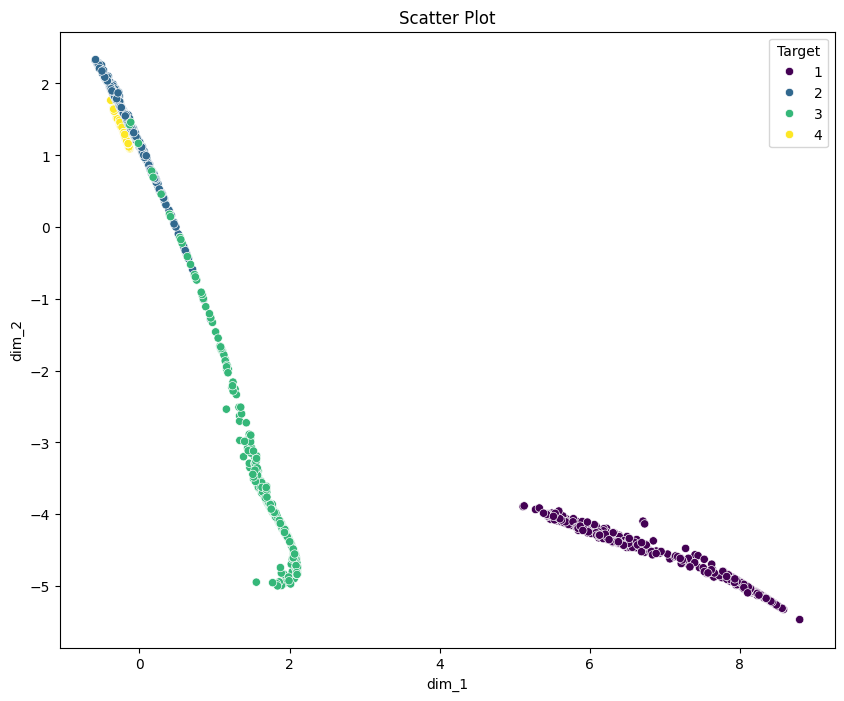

In [301]:
import numpy as np
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt

# 임베딩 결과와 타겟 레이블 데이터 예시 (임의로 생성)
test_embeddings =test_bye.detach().numpy()  # requires_grad=False로 설정한 데이터
test_target_labels = test_motor_targets  # 타겟 레이블 리스트



# 결과를 데이터 프레임으로 변환
df = pd.DataFrame(data={'dim_1': test_embeddings[:, 0], 'dim_2': test_embeddings[:, 1], 'Target': test_target_labels[:]})

# Seaborn을 사용하여 산점도 그리기
plt.figure(figsize=(10, 8))
sns.scatterplot(data=df, x='dim_1', y='dim_2', hue='Target', palette='viridis')

# 그래프 제목 추가
plt.title('Scatter Plot')

# 그래프 표시
plt.show()


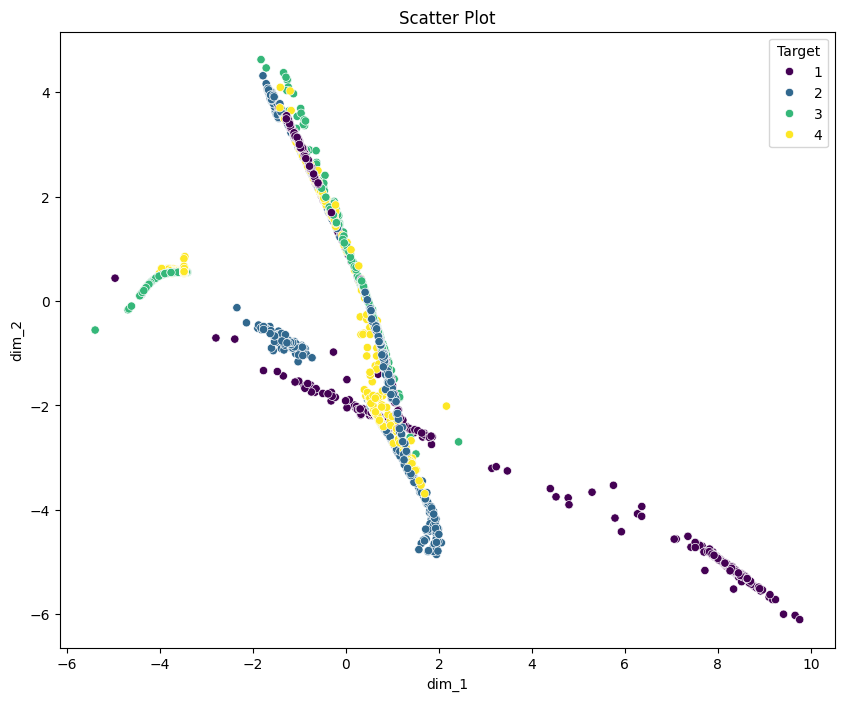

In [302]:
import numpy as np
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt

# 임베딩 결과와 타겟 레이블 데이터 예시 (임의로 생성)
val_embeddings =val_bye.detach().numpy()  # requires_grad=False로 설정한 데이터
val_target_labels = val_target_list  # 타겟 레이블 리스트



# 결과를 데이터 프레임으로 변환
df = pd.DataFrame(data={'dim_1': val_embeddings[:, 0], 'dim_2': val_embeddings[:, 1], 'Target': val_target_labels[:]})

# Seaborn을 사용하여 산점도 그리기
plt.figure(figsize=(10, 8))
sns.scatterplot(data=df, x='dim_1', y='dim_2', hue='Target', palette='viridis')

# 그래프 제목 추가
plt.title('Scatter Plot')

# 그래프 표시
plt.show()


In [303]:
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score

# StandardScaler를 초기화합니다.
scaler = StandardScaler()
X_scaled = scaler.fit_transform(val_embeddings)
# X 데이터를 스케일링합니다.

y = val_target_labels
# test_embeddings도 동일한 평균과 표준 편차를 사용하여 스케일링합니다.
test_embeddings_scaled = scaler.transform(pd.DataFrame(test_embeddings))

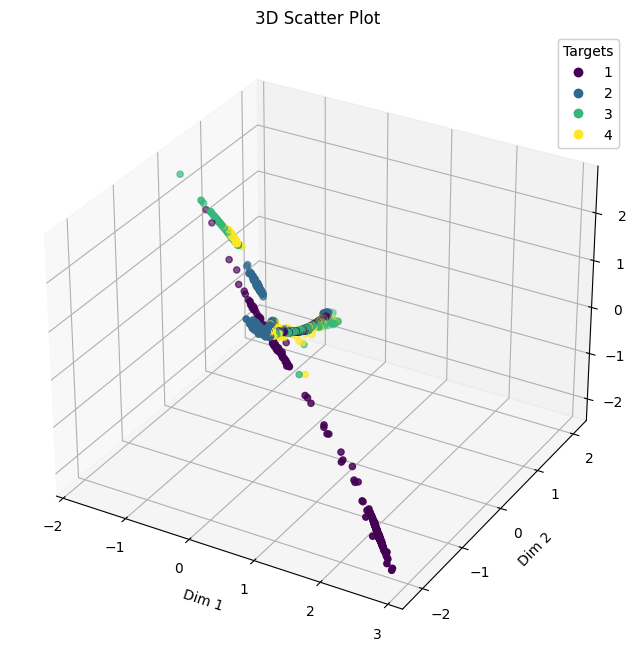

In [304]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Assuming val_embeddings has at least three dimensions
df = pd.DataFrame(data={
    'dim_1': X_scaled[:, 0],
    'dim_2': X_scaled[:, 1],
    'dim_3': X_scaled[:, 2],
    'Target': val_target_list[:]
})

# Create a 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Using scatter plot
scatter = ax.scatter(df['dim_1'], df['dim_2'], df['dim_3'], c=df['Target'], cmap='viridis')

# Adding a color bar
legend1 = ax.legend(*scatter.legend_elements(), loc="upper right", title="Targets")
ax.add_artist(legend1)

# Add labels and title
ax.set_xlabel('Dim 1')
ax.set_ylabel('Dim 2')
ax.set_zlabel('Dim 3')
plt.title('3D Scatter Plot')

# Show plot
plt.show()

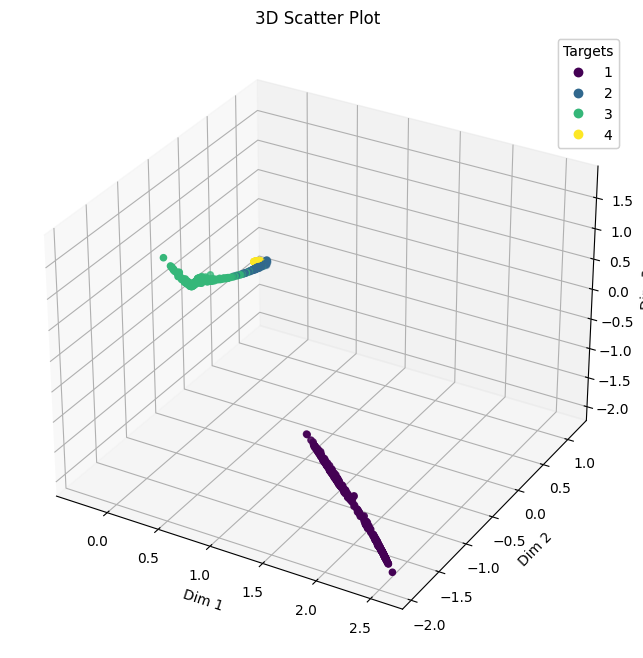

In [305]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Assuming val_embeddings has at least three dimensions
df = pd.DataFrame(data={
    'dim_1': test_embeddings_scaled[:, 0],
    'dim_2': test_embeddings_scaled[:, 1],
    'dim_3': test_embeddings_scaled[:, 2],
    'Target': test_target_labels[:]
})

# Create a 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Using scatter plot
scatter = ax.scatter(df['dim_1'], df['dim_2'], df['dim_3'], c=df['Target'], cmap='viridis')

# Adding a color bar
legend1 = ax.legend(*scatter.legend_elements(), loc="upper right", title="Targets")
ax.add_artist(legend1)

# Add labels and title
ax.set_xlabel('Dim 1')
ax.set_ylabel('Dim 2')
ax.set_zlabel('Dim 3')
plt.title('3D Scatter Plot')

# Show plot
plt.show()

In [306]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import RadiusNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import cross_val_score
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns



In [307]:
df = pd.DataFrame(X_scaled)
df["Target"] = val_target_list[:]
class1_mean = df.groupby("Target").mean().iloc[0,:]
class2_mean = df.groupby("Target").mean().iloc[1,:]
class3_mean = df.groupby("Target").mean().iloc[2,:]
class4_mean = df.groupby("Target").mean().iloc[3,:]

0.30858762495053427


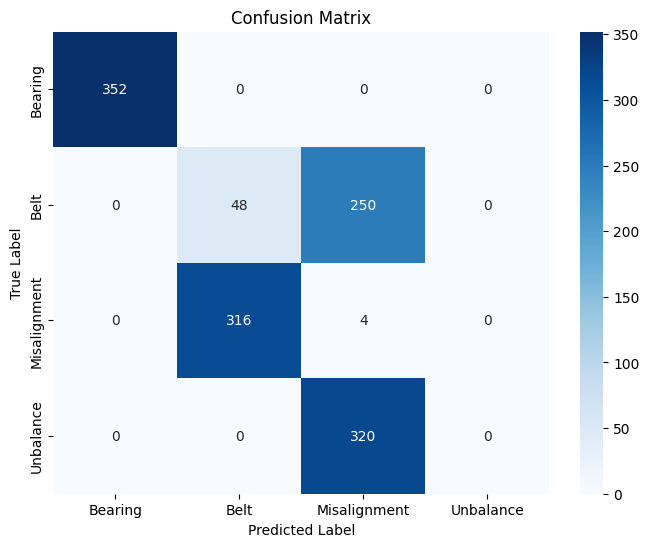

In [308]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import f1_score, confusion_matrix
from scipy.spatial.distance import cdist

# 코사인 유사도를 이용한 분류 함수 정의
def classify_with_cosine_similarity(test_data, class_means):
    # 코사인 유사도 계산
    similarities = cosine_similarity(test_data, class_means)

    # 가장 유사도가 높은 클래스를 예측 값으로 선택
    predictions = np.argmax(similarities, axis=1) + 1

    return predictions

# 클래스 평균을 배열로 변환
class_means = np.array([class1_mean, class2_mean, class3_mean, class4_mean])

# 테스트 데이터에 대해 분류 수행
predictions = classify_with_cosine_similarity(test_embeddings_scaled, class_means)

# F1 스코어 계산
f1 = f1_score(test_target_labels, predictions, average='weighted')
conf_matrix = confusion_matrix(test_target_labels, predictions)
print(f1)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', 
            xticklabels=["Bearing", "Belt", "Misalignment", "Unbalance"], 
            yticklabels=["Bearing", "Belt", "Misalignment", "Unbalance"])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

0.28750627701362425


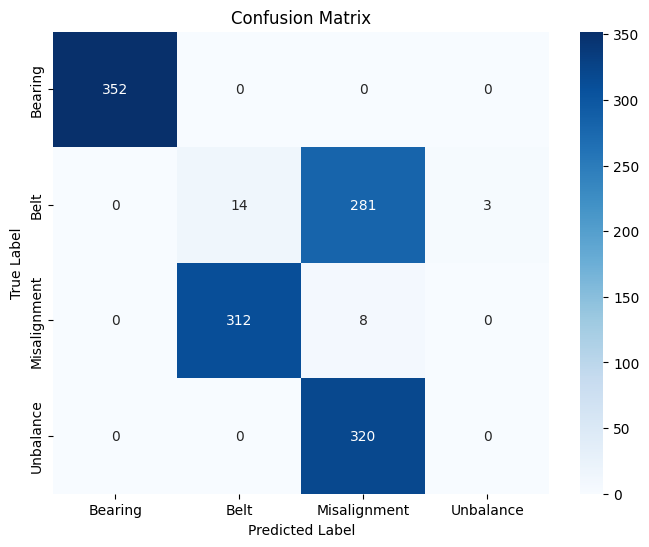

In [309]:
from sklearn.metrics import f1_score, confusion_matrix
from scipy.spatial.distance import cdist

# 맨해튼 거리를 이용한 분류 함수 정의
def classify_with_manhattan_distance(test_data, class_means):
    # 맨해튼 거리 계산
    distances = cdist(test_data, class_means, metric='cityblock')

    # 가장 거리가 짧은 클래스를 예측 값으로 선택
    predictions = np.argmin(distances, axis=1) + 1

    return predictions

# 클래스 평균을 배열로 변환
class_means = np.array([class1_mean, class2_mean, class3_mean, class4_mean])

# 테스트 데이터에 대해 분류 수행
predictions = classify_with_manhattan_distance(test_embeddings_scaled, class_means)

# F1 스코어 계산
f1 = f1_score(test_target_labels, predictions, average='weighted')

# Confusion Matrix 계산
conf_matrix = confusion_matrix(test_target_labels, predictions)
print(f1)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', 
            xticklabels=["Bearing", "Belt", "Misalignment", "Unbalance"], 
            yticklabels=["Bearing", "Belt", "Misalignment", "Unbalance"])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

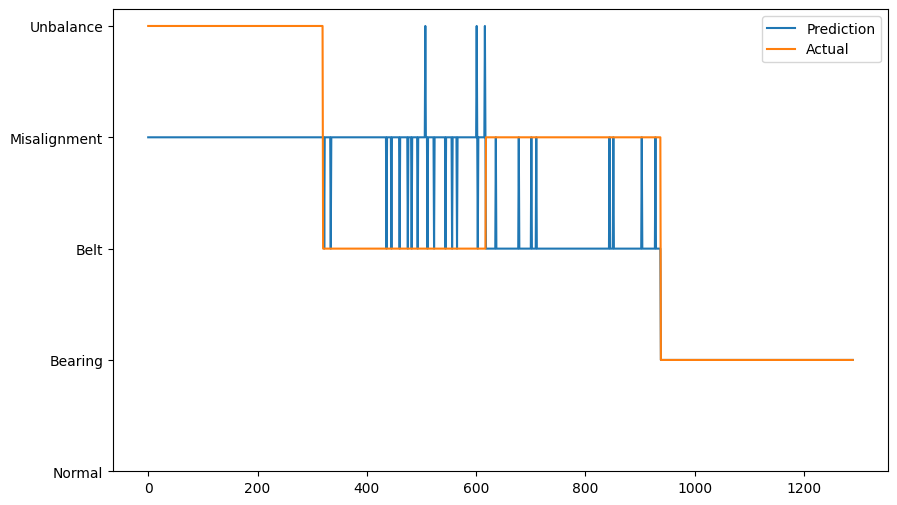

In [310]:
plt.figure(figsize=(10, 6))

# 예측값과 실제값을 그립니다.
plt.plot(predictions, label='Prediction')
plt.plot(test_target_labels, label='Actual')

# Y축 라벨을 설정합니다.
plt.yticks([0, 1, 2, 3, 4], ['Normal','Bearing', 'Belt', 'Misalignment', 'Unbalance'])

# 범례를 추가합니다.
plt.legend()

# 그래프를 표시합니다.
plt.show()

In [311]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(val_embeddings)
# X_scaled를 훈련 세트와 테스트 세트로 분할
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# k 값을 조정하여 교차 검증을 사용해 최적의 k 찾기
k_values = range(5, 151)  # 1부터 30까지의 k 값 범위
best_k = 0
best_score = 0

for k in k_values:
    model = KNeighborsClassifier(n_neighbors=k, metric= "cosine")
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')  # 또는 다른 적절한 스코어링 메서드 사용
    mean_score = np.mean(scores)
    if mean_score > best_score:
        best_score = mean_score
        best_k = k

print(f"Best k: {best_k}, Cross-validated Accuracy: {best_score:.2f}")

# 최적의 k를 사용하여 모델을 훈련하고 test_embeddings_scaled에 대해 성능 평가
final_model = KNeighborsClassifier(n_neighbors=best_k, metric= "cosine")
final_model.fit(X_train, y_train)
y_pred = final_model.predict(test_embeddings_scaled)

# 정확도와 F1 스코어 계산
accuracy = accuracy_score(test_target_labels, y_pred)
f1 = f1_score(test_target_labels, y_pred, average='weighted')

print(f'Final Test Accuracy: {accuracy:.2f}')
print(f'Final Test F1 Score: {f1:.2f}')

Best k: 7, Cross-validated Accuracy: 0.76
Final Test Accuracy: 0.33
Final Test F1 Score: 0.29


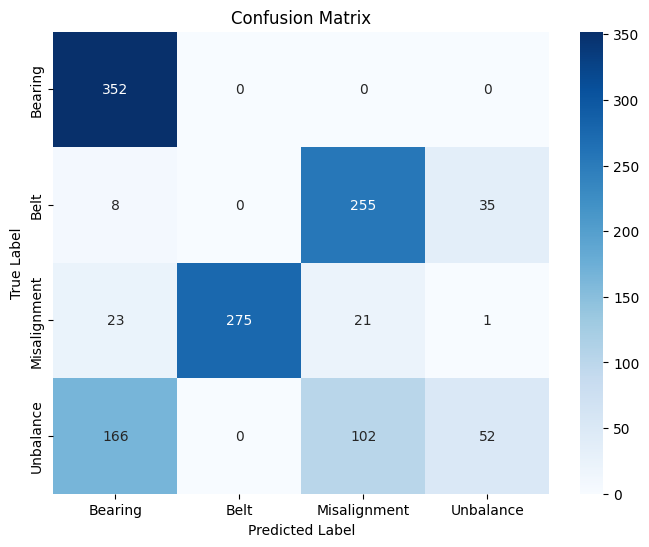

In [312]:

# Confusion matrix를 시각화합니다.
conf_matrix = confusion_matrix(test_target_labels, y_pred)

# Confusion matrix를 시각화합니다.
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', 
            xticklabels=["Bearing", "Belt", "Misalignment", "Unbalance"], 
            yticklabels=["Bearing", "Belt", "Misalignment", "Unbalance"])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

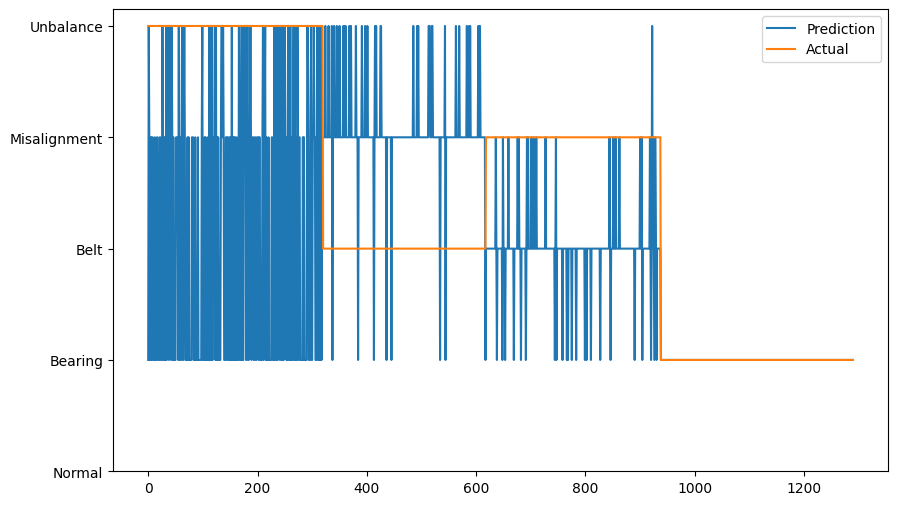

In [313]:
plt.figure(figsize=(10, 6))

# 예측값과 실제값을 그립니다.
plt.plot(y_pred, label='Prediction')
plt.plot(test_target_labels, label='Actual')

# Y축 라벨을 설정합니다.
plt.yticks([0, 1, 2, 3, 4], ['Normal','Bearing', 'Belt', 'Misalignment', 'Unbalance'])

# 범례를 추가합니다.
plt.legend()

# 그래프를 표시합니다.
plt.show()

In [314]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score
svm_model = SVC()

svm_model.fit(X_scaled, y)

# 스케일링된 테스트 데이터로 예측을 수행합니다.
y_pred = svm_model.predict(test_embeddings_scaled)

# 정확도와 F1 스코어를 계산합니다.
accuracy = accuracy_score(test_target_labels, y_pred)
f1 = f1_score(test_target_labels, y_pred, average='weighted')

print(f'Accuracy: {accuracy:.2f}')
print(f'F1 Score: {f1:.2f}')

Accuracy: 0.29
F1 Score: 0.26


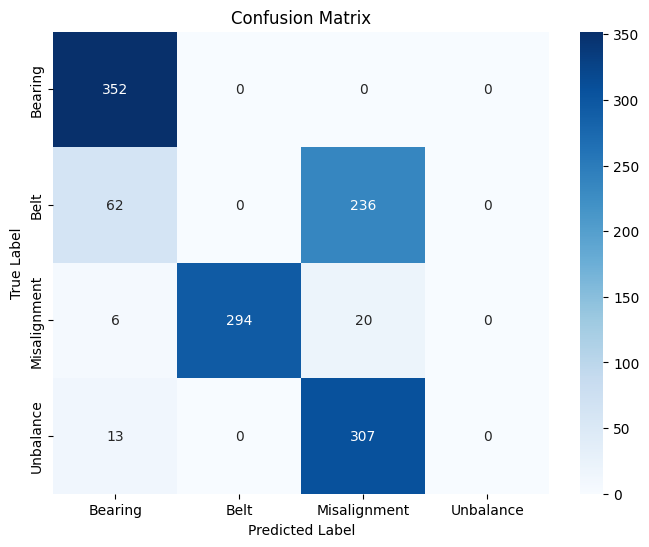

In [315]:

# Confusion matrix를 시각화합니다.
conf_matrix = confusion_matrix(test_target_labels, y_pred)

# Confusion matrix를 시각화합니다.
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', 
            xticklabels=["Bearing", "Belt", "Misalignment", "Unbalance"], 
            yticklabels=["Bearing", "Belt", "Misalignment", "Unbalance"])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

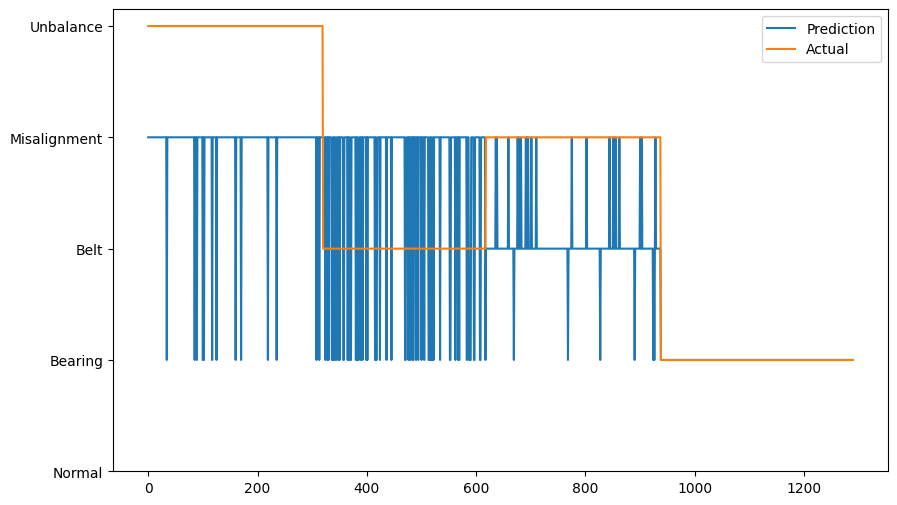

In [316]:
plt.figure(figsize=(10, 6))

# 예측값과 실제값을 그립니다.
plt.plot(y_pred, label='Prediction')
plt.plot(test_target_labels, label='Actual')

# Y축 라벨을 설정합니다.
plt.yticks([0, 1, 2, 3, 4], ['Normal','Bearing', 'Belt', 'Misalignment', 'Unbalance'])

# 범례를 추가합니다.
plt.legend()

# 그래프를 표시합니다.
plt.show()

In [317]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

# KNN 모델
knn_model = KNeighborsClassifier(n_neighbors=best_k)

# SVM 모델 (확률 추정 활성화)
svm_model = SVC(probability=True)

# 모델 훈련
knn_model.fit(X_train, y_train)
svm_model.fit(X_train, y_train)

# 테스트 데이터에 대한 클래스별 확률 예측
prob_knn = knn_model.predict_proba(test_embeddings_scaled)
prob_svm = svm_model.predict_proba(test_embeddings_scaled)

# 평균 확률 계산
average_prob = (prob_knn + prob_svm) / 2

# 최종 예측 (가장 높은 평균 확률을 가진 클래스 선택)
ensemble_predictions = np.argmax(average_prob, axis=1) + 1

# 성능 평가
ensemble_accuracy = accuracy_score(test_target_labels, ensemble_predictions)
ensemble_f1 = f1_score(test_target_labels, ensemble_predictions, average='weighted')

print(f'Ensemble Model Accuracy: {ensemble_accuracy:.2f}')
print(f'Ensemble Model F1 Score: {ensemble_f1:.2f}')


Ensemble Model Accuracy: 0.29
Ensemble Model F1 Score: 0.24


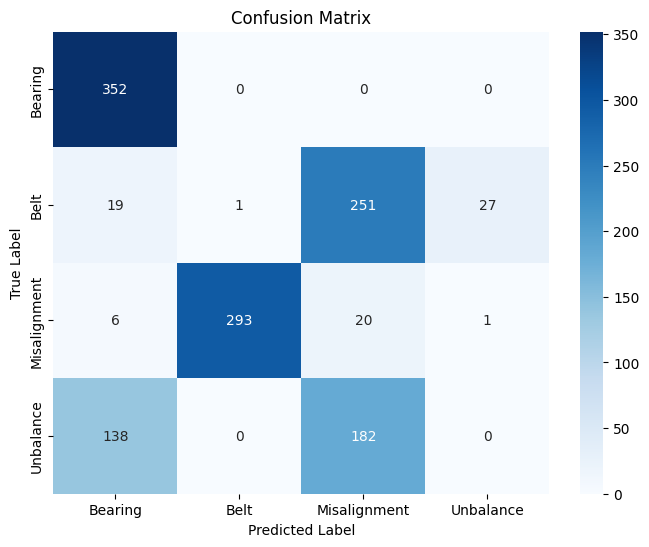

In [318]:

# Confusion matrix를 시각화합니다.
conf_matrix = confusion_matrix(test_target_labels, ensemble_predictions)

# Confusion matrix를 시각화합니다.
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', 
            xticklabels=["Bearing", "Belt", "Misalignment", "Unbalance"], 
            yticklabels=["Bearing", "Belt", "Misalignment", "Unbalance"])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

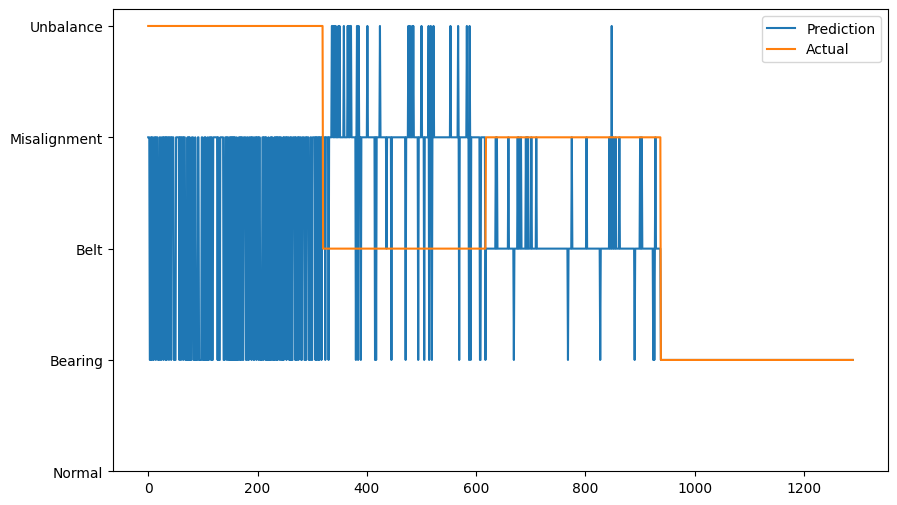

In [319]:
plt.figure(figsize=(10, 6))

# 예측값과 실제값을 그립니다.
plt.plot(ensemble_predictions, label='Prediction')
plt.plot(test_target_labels, label='Actual')

# Y축 라벨을 설정합니다.
plt.yticks([0, 1, 2, 3, 4], ['Normal','Bearing', 'Belt', 'Misalignment', 'Unbalance'])

# 범례를 추가합니다.
plt.legend()

# 그래프를 표시합니다.
plt.show()